# Análisis lineal por discriminante (LDA)

LDA es una técnica de reducción de dimensionalidad supervisada. El objetivo es proyectar un conjunto de datos en un espacio de menor dimensión con una buena separabilidad de clases para evitar el sobreajuste ("maldición de la dimensionalidad") y también reducir los costos computacionales. Básicamente, la ventaja adicional que ofrece LDA sobre PCA es abordar el sobreajuste.

Pasos para realizar un LDA (Fisher).
- Calcular los vectores de medias de dimensión $r$ para las distintas clases de nuestro conjunto de datos.
- Calcular las matrices de tipo *scatter*.
- Calcular los eigenvectores con sus respectivos eigenvalores.
- Limpieza de datos con respecto a un orden y se eligen los eigenvalores de manera decreciente y escogemos los $k$ eigenvalores más lejanos y formamos la matriz de tamaño $r\times k$.
- Transformamos ortogonalmente esta base de datos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Ejemplo 1



In [2]:
columnas = ["var","skewness","curtosis","entropy","class"]
banco = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/\
data_banknote_authentication.txt",index_col=False, names = columnas)

banco.head()

,var,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


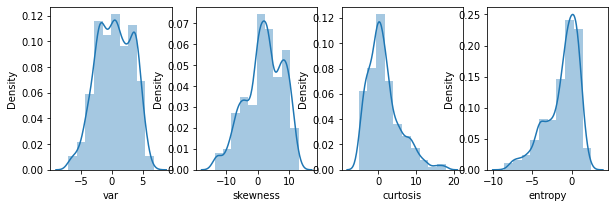

In [3]:
f, ax = plt.subplots(1, 4, figsize=(10,3))
vis1 = sns.distplot(banco["var"],bins=10, ax= ax[0])
vis2 = sns.distplot(banco["skewness"],bins=10, ax=ax[1])
vis3 = sns.distplot(banco["curtosis"],bins=10, ax= ax[2])
vis4 = sns.distplot(banco["entropy"],bins=10, ax=ax[3])
f.savefig('subplot.png')

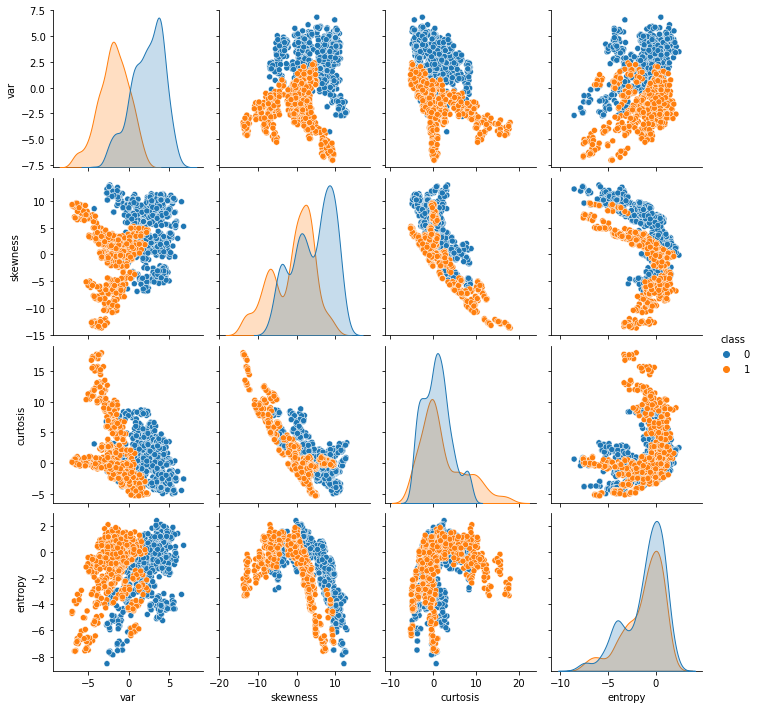

In [4]:
sns.pairplot(banco, hue="class")

Ahora, calcularemos los vectores de medias de 4 dimensiones para ambas clases (4 = número de características). A diferencia de PCA, la estandarización de los datos no es necesaria en LDA ya que no afecta la salida. La razón por la que no hay efecto de la estandarización en los resultados principales en LDA es que LDA descompone la relación de las covarianzas, y no la covarianza en sí misma  (como lo hace PCA).

In [5]:
mean_vec = []
for i in banco["class"].unique():
    mean_vec.append( np.array((banco[banco["class"]==i].mean()[:4]) ))
mean_vec 

[array([ 2.27668601,  4.25662719,  0.79671797, -1.14764028]),
 array([-1.86844256, -0.99357612,  2.14827101, -1.24664075])]

### Matrices de dispersión

In [6]:
SW = np.zeros((4,4))
for i in range(1,4): 
    per_class_sc_mat = np.zeros((4,4))
    for j in range(banco[banco["class"]==i].shape[0]):
        row, mv = banco.loc[j][:4].values.reshape((4,1)), mean_vec[i].reshape(4,1)
        per_class_sc_mat += (row-mv).dot((row-mv).T)
    SW += per_class_sc_mat
print('Matriz de dispersión SW:\n', SW)
overall_mean = np.array(banco.drop("class", axis=1).mean())
SB = np.zeros((4,4))
for i in range(2): 
    n = banco[banco["class"]==i].shape[0]
    mv = mean_vec[i].reshape(4,1)
    overall_mean = overall_mean.reshape(4,1) 
    SB += n * (mv - overall_mean).dot((mv - overall_mean).T)
print('Matriz de dispersión SB:\n', SB)

Matriz de dispersión SW:
 [[ 12894.02618964  12388.17949578  -5025.6093967    1110.90896782]
 [ 12388.17949578  34177.22271176 -12505.24344685  -4576.31987213]
 [ -5025.6093967  -12505.24344685   7858.82866205   1824.14383828]
 [  1110.90896782  -4576.31987213   1824.14383828   2876.82304762]]
Matriz de dispersión SB:
 [[ 5.82112206e+03  7.37300999e+03 -1.89802442e+03  1.39029178e+02]
 [ 7.37300999e+03  9.33862504e+03 -2.40403016e+03  1.76093803e+02]
 [-1.89802442e+03 -2.40403016e+03  6.18866372e+02 -4.53315997e+01]
 [ 1.39029178e+02  1.76093803e+02 -4.53315997e+01  3.32051315e+00]]


In [7]:
e_vals, e_vecs = np.linalg.eig(np.linalg.inv(SW).dot(SB))
print('Eigenvectores \n%s' %e_vecs)
print('\nEigenvalores \n%s' %e_vals)

Eigenvectores 
[[ 0.74375324  0.35204713 -0.15475989  0.11717137]
 [ 0.34589513 -0.48432887  0.25549525  0.12343154]
 [ 0.57194183 -0.80084373  0.5737136   0.8723993 ]
 [-0.00837995  0.01173376  0.76264294  0.45820845]]

Eigenvalores 
[ 5.27056121e-01 -5.55111512e-17  7.42609369e-18  5.64588829e-17]


Ahora, necesitamos seleccionar los eigenvectores de los k superiores correspondientes a los eigenvectores de los k superiores. La selección de k depende de la posible retención de varianza con cada dirección. Para fines de compresión de datos, generalmente optamos por una retención de varianza del 99%, mientras que para la visualización hacemos la dimensión a 2 o 3. Aquí, tomamos los 2 valores propios principales correspondientes a los vectores propios para fines de visualización. Pero el vector propio pertenece al valor propio más grande retiene casi el 100% de varianza, por lo que también podemos descartar otros 3. La matriz de transformación W será:

In [8]:
e_pairs = [(np.abs(e_vals[i]), e_vecs[:,i]) for i in range(len(e_vals))]


e_pairs.sort()
e_pairs.reverse()

print('Eigenvalores:')
for i in e_pairs:
    print(i[0]) 

Eigenvalores:
0.5270561214857215
5.645888292239743e-17
5.551115123125783e-17
7.426093693670243e-18


In [9]:
var_exp = [(i / sum(e_vals))*100 for i in sorted(e_vals, reverse=True)]
var_exp 

[99.99999999999997,
 1.071211975742643e-14,
 1.4089758928777423e-15,
 -1.0532303670959579e-14]

In [10]:
W = np.hstack((e_pairs[0][1].reshape(4,1), e_pairs[1][1].reshape(4,1)))
print('Matriz W:\n', W.real)

Matriz W:
 [[ 0.74375324  0.11717137]
 [ 0.34589513  0.12343154]
 [ 0.57194183  0.8723993 ]
 [-0.00837995  0.45820845]]


In [11]:
X = banco.iloc[:,0:4].values
y = banco.iloc[:,4].values 

X_lda = X.dot(W)
banco["PC1"] = X_lda[:,0]
banco["PC2"] = X_lda[:,1]

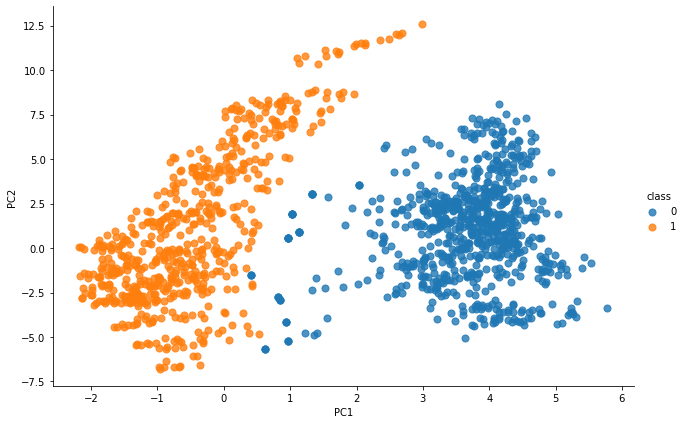

In [12]:
vis = sns.lmplot(data = banco[["PC1","PC2","class"]], 
                 x = "PC1", y = "PC2",fit_reg=False, hue = "class",\
                 size = 6, aspect=1.5, scatter_kws = {'s':50}, )
vis.savefig("pca.png")

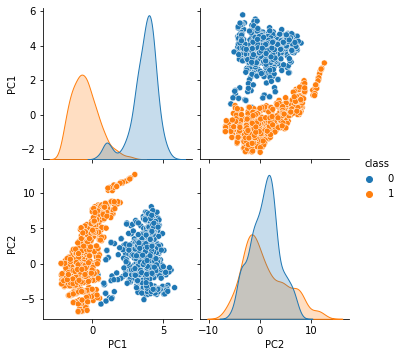

In [33]:
sns.pairplot(banco[["PC1","PC2","class"]], hue="class")

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA(n_components=2)
X_lda = model.fit_transform(X, y)

In [36]:
print(model.explained_variance_ratio_.cumsum())

[0.9912126 1.       ]


## Ejemplo 2

In [13]:
iris_dict = {i : label for i, label in zip(
    range(4),
    ("sepal length in cm",
     "sepal width in cm",
     "petal lenght in cm",
     "petal width in cm",)
) }

In [14]:
df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(iris_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) 

df.head()

,sepal length in cm,sepal width in cm,petal lenght in cm,petal width in cm,class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## LDA para Iris

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

In [16]:
X = std.fit_transform(df.iloc[:,range(0,4)].values)

y = df["class label"].values 

encoder = LabelEncoder()

label_encoder = encoder.fit(y)

y = label_encoder.transform(y) + 1

label_dict = {1: "Setosa", 2: "Versicolor", 3: "Virginica"}

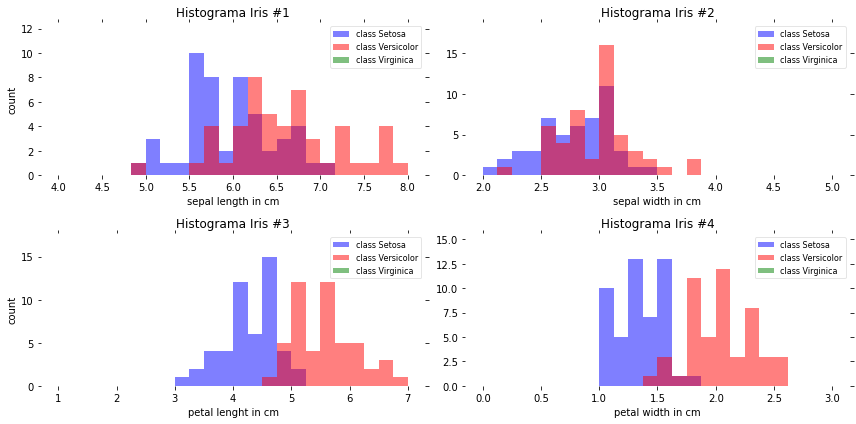

In [39]:
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

  
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(iris_dict[cnt])
    ax.set_title('Histograma Iris #%s' %str(cnt+1))

    
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

In [40]:
y = encoder.fit_transform(df["class label"].values)

In [41]:
SW = np.zeros((4,4))

for i in range(3):
  SW += np.cov(X[y==i].T)

In [21]:
SW

array([[1.16722735, 0.78296373, 0.34611786, 0.18386817],
       [0.78296373, 1.8615894 , 0.21806165, 0.30505192],
       [0.34611786, 0.21806165, 0.1796358 , 0.09541594],
       [0.18386817, 0.30505192, 0.09541594, 0.21784923]])

In [22]:
N = np.bincount(y) 
vect=[]

[vect.append(np.mean(X[y==i], axis=0)) for i in range(3)]

media = np.mean(X, axis = 0)

SM = np.zeros((4,4))

for i in range(3):
     SM+=N[i]*(((vect[i]-media).reshape(4,1)).dot(((vect[i]-media).reshape(1,4))))

In [23]:
SM

array([[ 92.80585961, -54.77061003, 113.8033484 , 113.68350465],
       [-54.77061003,  58.78211947, -73.76243518, -68.42915731],
       [113.8033484 , -73.76243518, 141.19784603, 139.73818372],
       [113.68350465, -68.42915731, 139.73818372, 139.3253878 ]])

In [24]:
egvl, egvt = np.linalg.eig(np.linalg.inv(SW).dot(SM))
egp =[(np.abs(egvl[i]), egvt[:,i]) for i in range(3) ]

In [25]:
egp = sorted(egp, key=lambda k: k[0], reverse=True) 

In [26]:
W=np.hstack((egp[0][1][:, ].reshape(4,1),egp[1][1][:, ].reshape(4,1))).real
X_train_lda = X.dot(W)

In [27]:
data=pd.DataFrame(X_train_lda)
data['class']=y
data.columns=["LD1","LD2","class"]
data.head()

,LD1,LD2,class
0,-1.790936,-0.115414,0
1,-1.583202,0.265463,0
2,-1.663881,0.083657,0
3,-1.514646,0.225901,0
4,-1.807076,-0.189973,0


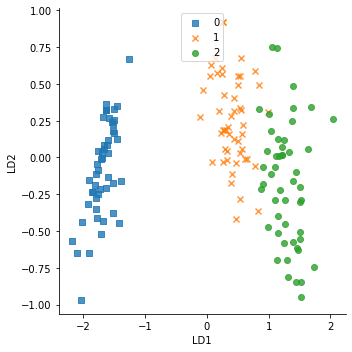

In [28]:
import seaborn as sns

markers = ['s', 'x','o']
sns.lmplot(x="LD1", y="LD2", data=data, markers=markers,fit_reg=False, hue='class', legend=False)
plt.legend(loc='upper center')
plt.show()

varianza explicada (primeras dos componentes): [0.92461872 0.05306648]


Text(0.5, 1.0, 'PCA IRIS ')

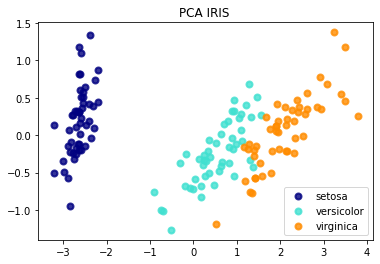

In [42]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)


print(
    "varianza explicada (primeras dos componentes): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA IRIS ")



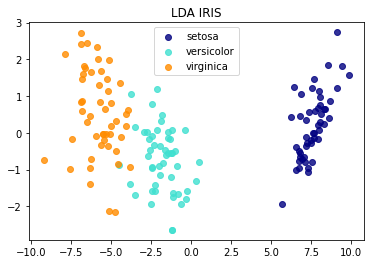

In [43]:
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA IRIS")

plt.show()